In [1]:
library(reticulate)
use_condaenv(condaenv="pyr2", conda="/data8t_0/hms/anaconda3/bin/conda")
# use_python("/data8t_0/hms/anaconda3/envs/pyr2/bin/python")
# umap<-import('umap')

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(dplyr)))
datasetName = "colon_colon_Parikh2019"
dataFormat = 'tsv'
setwd(paste0("/stor/public/hcad/db_v1/",datasetName,"/"))

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv"),h = T,sep='\t',row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tsv.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [4]:
ncol(data.matrix)

[1] 11175

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


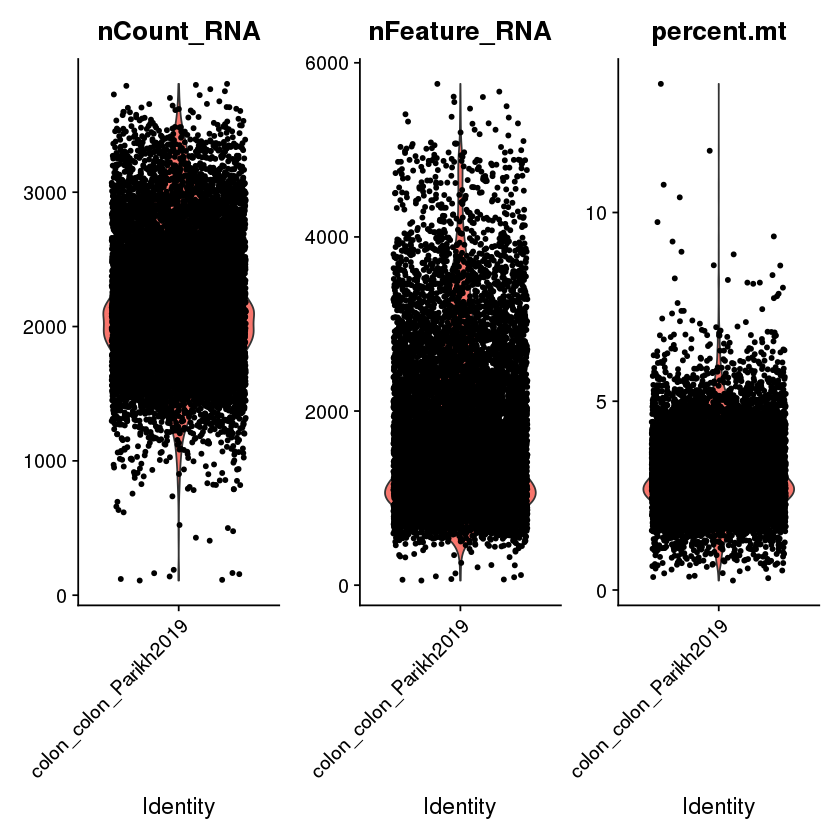

In [20]:
# Pre-processing
min.features = 20
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [21]:
dataobj = subset(dataobj,sample_status=='normal')

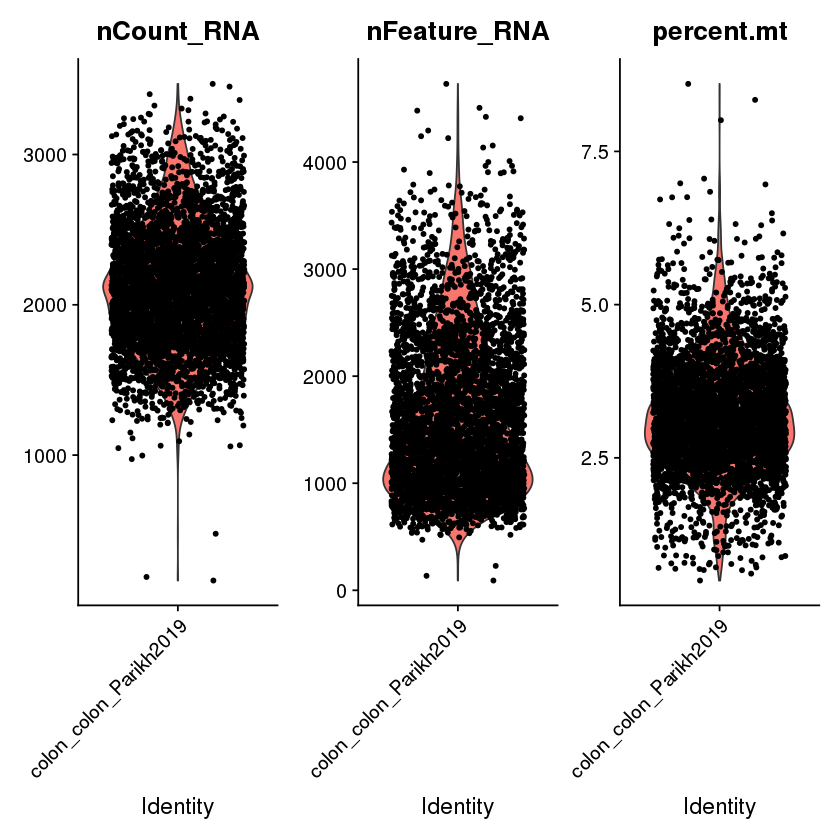

In [22]:
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [25]:
dataobj

An object of class Seurat 
58690 features across 4249 samples within 1 assay 
Active assay: RNA (58690 features, 0 variable features)

In [23]:
head(dataobj[[]])

,orig.ident,nCount_RNA,nFeature_RNA,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age,cell_cluster,percent.mt
,<fct>,<dbl>,<int>,<fct>,<fct>,<lgl>,<fct>,<fct>,<lgl>,<fct>,<lgl>,<dbl>
AAACCTGGTAATCGTC.A1,colon_colon_Parikh2019,1990.073,2110,Colon,Colon,NA,normal,A1,NA,Adult,NA,3.867940
AAACGGGAGCTTTGGT.A1,colon_colon_Parikh2019,2184.032,1354,Colon,Colon,NA,normal,A1,NA,Adult,NA,2.500265
AAACGGGTCTGGTATG.A1,colon_colon_Parikh2019,1695.304,806,Colon,Colon,NA,normal,A1,NA,Adult,NA,2.753521
AAAGTAGAGAACTGTA.A1,colon_colon_Parikh2019,2023.887,1184,Colon,Colon,NA,normal,A1,NA,Adult,NA,3.032127
AAAGTAGCAGGGAGAG.A1,colon_colon_Parikh2019,1956.514,1539,Colon,Colon,NA,normal,A1,NA,Adult,NA,3.428912
AAAGTAGGTTCGTTGA.A1,colon_colon_Parikh2019,1897.726,1552,Colon,Colon,NA,normal,A1,NA,Adult,NA,4.407137


In [26]:
unique(dataobj$sample_status)

[1] normal
3 Levels: inflamed Ulcerative Colitis ... normal

In [27]:
warnings('off')
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)

In [28]:
# *--------------------Load reference table--------------------*
print("=========Loading Reference Table=========")
ref_table_raw <- read.csv("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/GeneSymbolRef_SelectAll_upd0731.csv", header=TRUE, na.strings=TRUE, stringsAsFactors=FALSE)
# print(dim(ref_table_raw))
print("Finished")
# *--------------------Load total gene list--------------------*
print("=========Processing Gene List=========")
total_gene_list_raw = read.table("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/total_gene_list_43878.txt", 
                                 header=TRUE, sep='\t', fill=TRUE, stringsAsFactors=FALSE)
total_gene_list = total_gene_list_raw[,1]
# Seurat changes all "_" to "-".
total_gene_list <- str_replace(total_gene_list, "_", "-")
print("The length of gene list is: ")
print(length(total_gene_list))
print("Finished")
print("=========Processing Reference Table=========")
# Separate dataframe to previous and alias symbol sub-dataframe
# Remove duplicates and empty values
ref_table_raw <- ref_table_raw[,c("Approved.symbol","Alias.symbol","Previous.symbol")]
ref_table <- ref_table_raw[ref_table_raw[,"Previous.symbol"]!="" | ref_table_raw[,"Alias.symbol"]!="",]
# Seurat changes all "_" to "-".
ref_table$Previous.symbol <- str_replace(ref_table$Previous.symbol, "_", "-")
ref_table$Alias.symbol <- str_replace(ref_table$Alias.symbol, "_", "-")
ref_table$Approved.symbol <- str_replace(ref_table$Approved.symbol, "_", "-")
# print(dim(ref_table))
ref_table_prev <- unique(ref_table[,c("Approved.symbol","Previous.symbol")])
ref_table_prev <- ref_table_prev[ref_table_prev[,"Previous.symbol"]!="",]
ref_table_alia <- unique(ref_table[,c("Approved.symbol","Alias.symbol")])
ref_table_alia <- ref_table_alia[ref_table_alia[,"Alias.symbol"]!="",]
# print(dim(ref_table_prev))
# print(dim(ref_table_alia))
print("Finished")

# *--------------------Load query data--------------------*
print("=========Loading Query Data=========")
query_data <- as.data.frame(as.matrix(dataobj@assays$RNA@data))
query_gene_list <- rownames(dataobj)
print("The shape of query data is: ")
print(dim(query_data))
print("Print out first 5 genes in query data, in case something wrong happens in data loading: ")
print(query_gene_list[1:5])
print("Finished")

# *--------------------Perform gene name uniform--------------------*
print("=========Performing Gene Symbol Uniform=========")
print("Performing gene symbol uniform, this step may take several minutes")
gene_appearance_list <- data.frame(gene_name=total_gene_list, appearance=rep(FALSE, length(total_gene_list)))
outlier_gene_list <- c()

result_data <- query_data
result_data$genenames <- rownames(result_data)
report <- data.frame(Original.Name=character(), Modified.Name=character(), Status=character(), stringsAsFactors=FALSE)

for (i in c(1:length(query_gene_list))){
  gene_name <- query_gene_list[i]
  # Modify gene symbols, both "Alias symbol" and "Previous symbol" are used. 
  if(sum(ref_table_prev["Previous.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_prev["Previous.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
    
  else if(sum(ref_table_alia["Alias.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_alia["Alias.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
  
  # Gene name not found
  else{
    report[i,] <- c(gene_name, gene_name, "No Change")
    if(gene_name %in% total_gene_list){
      gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
    }
    else{
      outlier_gene_list <- c(outlier_gene_list, gene_name)
    }
  }
}
print("Finished")

# *--------------------Construct uniform output--------------------*
print("=========Building Output Matrix=========")
result_data_grouped <- result_data %>% group_by(genenames) %>% summarise_at(vars(-group_cols()), mean)
result_data_sub <- as.data.frame(result_data_grouped)[which(!result_data_grouped$genenames %in% outlier_gene_list),]
result_data_out <- subset(result_data_sub, select = -genenames )
rownames(result_data_out) <- result_data_sub$genenames
print("Shape of processed query data: ")
print(dim(result_data_out))

add_df <- data.frame(matrix(nrow=sum(gene_appearance_list$appearance==FALSE),ncol=dim(result_data)[2]-1, 0))
rownames(add_df) <- gene_appearance_list$gene_name[!gene_appearance_list$appearance]
colnames(add_df) <- colnames(result_data_out)

result_data_out <- rbind(result_data_out, add_df)
print("Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged.")
print(dim(result_data_out))
print("Finished")

[1] "=========Loading Reference Table========="
[1] "Finished"
[1] "=========Processing Gene List========="
[1] "The length of gene list is: "
[1] 43878
[1] "Finished"
[1] "=========Processing Reference Table========="
[1] "Finished"
[1] "=========Loading Query Data========="
[1] "The shape of query data is: "
[1] 58690  4249
[1] "Print out first 5 genes in query data, in case something wrong happens in data loading: "
[1] "DDX11L1"    "WASH7P"     "MIR6859-2"  "MIR1302-11" "MIR1302-9" 
[1] "Finished"
[1] "=========Performing Gene Symbol Uniform========="
[1] "Performing gene symbol uniform, this step may take several minutes"
[1] "Finished"
[1] "=========Building Output Matrix========="
[1] "Shape of processed query data: "
[1] 33847  4249
[1] "Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged."
[1] 43878  4249
[1] "Finished"


In [29]:
dataobj <- CreateSeuratObject(result_data_out,meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Warning message in CreateSeuratObject(result_data_out, meta.data = data.metadata):
“Some cells in meta.data not present in provided counts matrix.”
Centering and scaling data matrix



PC_ 1 
Positive:  SRGN, CD52, RGS1, CCL5, HCST, PTPRC, CD3E, ARHGDIB, CD7, SAMSN1 
	   LAPTM5, HOPX, NKG7, CREM, EVL, SYTL3, VIM, CXCR4, CORO1A, ZNF331 
	   CD37, CST7, CD48, GZMA, KLRB1, LSP1, CD3D, TRAC, GPR65, CLEC2D 
Negative:  KRT18, KRT8, CLDN3, SMIM22, PIGR, C19orf33, C15orf48, CLDN4, KRT19, ELF3 
	   CST3, FXYD3, CLDN7, EPCAM, TMEM54, IFI27, TSPAN8, CKB, FABP1, CA2 
	   TSPAN1, C10orf99, KRT20, MISP, PRSS3, UQCRQ, SLC26A3, ETHE1, CDHR5, TXN 
PC_ 2 
Positive:  NUPR1, RPS2, RPL10A, RARRES2, RPS23, RPS17, RPL22, STARD10, PPP1R1B, RPL6 
	   SNHG29, RPSA, RPS3A, SNHG5, SPINK1, ATP5MC1, RPL23, CXCL3, GADD45GIP1, SOX4 
	   DDX21, MRPL12, RPL5, RPS13, IGFBP2, RANBP1, SNORC, NCL, CD320, NHP2 
Negative:  CEACAM7, CEACAM1, IL32, GUCA2A, MS4A12, SLC26A3, GUCA2B, AQP8, LINC01133, CEACAM6 
	   ATP1B3, MALL, RHOC, CDA, SLC51B, EMP1, HPGD, CLCA4, CA4, ANPEP 
	   C2orf88, DHRS9, TMIGD1, C11orf86, KRT20, FTH1P10, MYO15B, PKIB, C12orf75, SCNN1B 
PC_ 3 
Positive:  ARPC3, OST4, NDUFA4, MICOS10, SLC

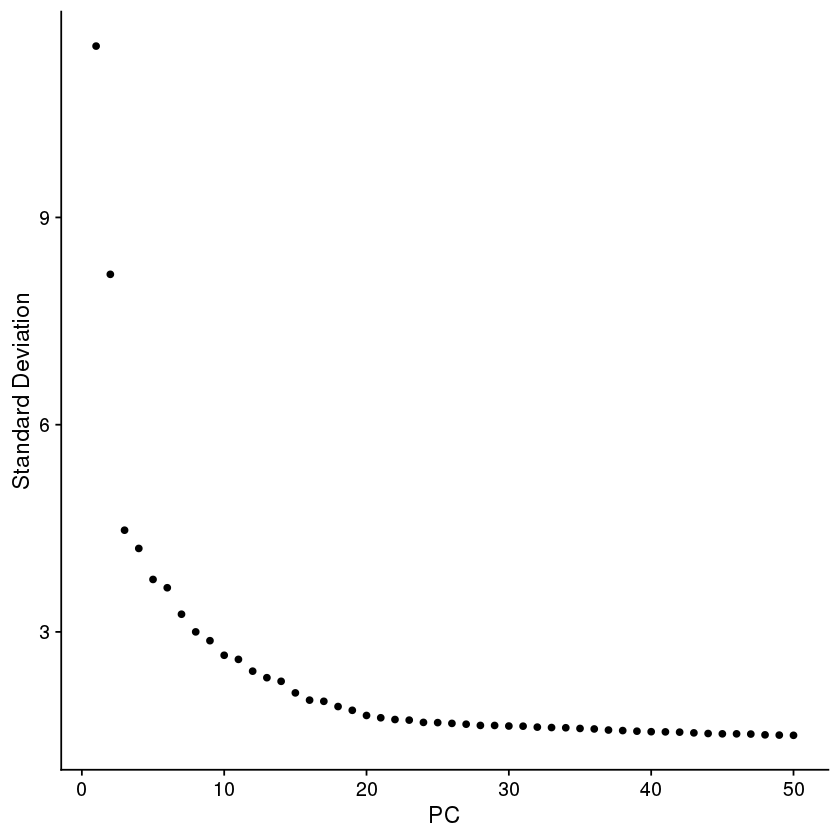

In [30]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj),npcs=50)
# Determine the ‘dimensionality’ of the dataset according to elbow plot
ElbowPlot(dataobj,ndim=50) 

In [31]:
pcDim = 30 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph

Computing SNN



In [32]:
dataobj <- FindClusters(dataobj, resolution = 0.3, n.start = 5)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4249
Number of edges: 144532

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.9034
Number of communities: 9
Elapsed time: 0 seconds


In [33]:
dataobj <- RunUMAP(dataobj,dims=1:pcDim)

12:48:26 UMAP embedding parameters a = 0.9922 b = 1.112

12:48:26 Read 4249 rows and found 30 numeric columns

12:48:26 Using Annoy for neighbor search, n_neighbors = 30

12:48:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

12:48:27 Writing NN index file to temp file /tmp/RtmpOKQEWR/file8d2e3e3fca51

12:48:27 Searching Annoy index using 1 thread, search_k = 3000

12:48:29 Annoy recall = 100%

12:48:29 Commencing smooth kNN distance calibration using 1 thread

12:48:30 Initializing from normalized Laplacian + noise

12:48:30 Commencing optimization for 500 epochs, with 169342 positive edges

12:48:45 Optimization finished



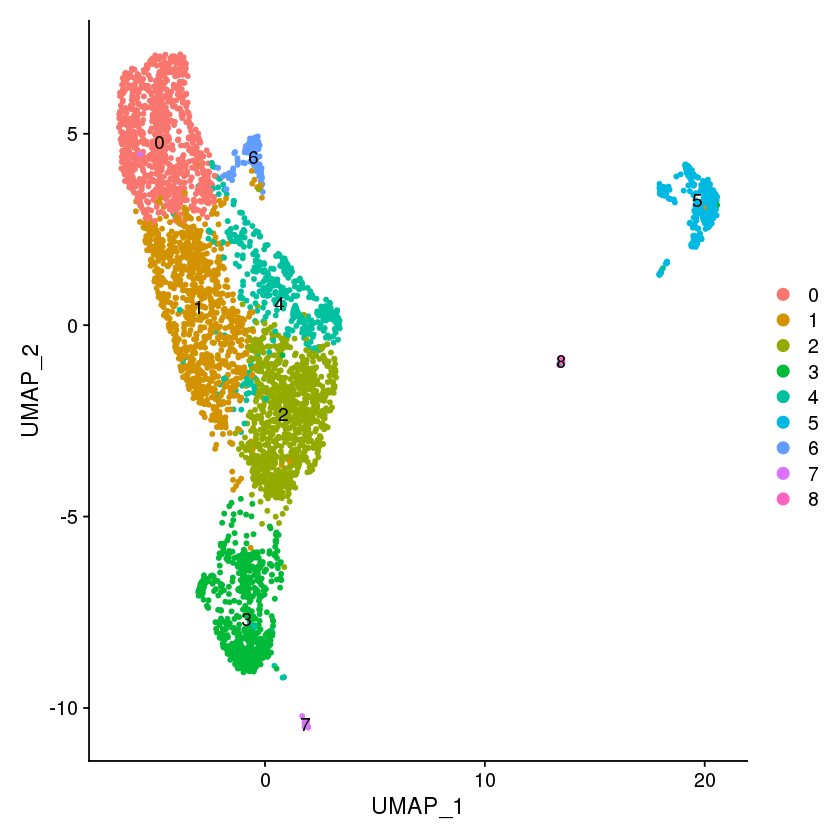

In [34]:
p_umap=DimPlot(dataobj,label = TRUE, pt.size=1)
p_umap

In [45]:
new.cluster.ids <- c("Colon-Epithelial tissue-Enterocyte-AQP8 SLC26A3",
                     "Colon-Epithelial tissue-Epithelial cell-SELENBP1", 
                     "Colon-Connective tissue-Fibroblast-RARRES2",
                     "Colon-Epithelial tissue-Goblet cell-ITLN1 CLCA1",
                     "Colon-Epithelial tissue-Enterocyte-RNF186",
                     "Colon-Connective tissue-Macrophage-CCL5",
                     "Colon-Epithelial tissue-Enterocyte-BEST4",
                     "Unclassified",
                     "Colon-Connective tissue-Mast cell-TPSB2")

In [46]:
subset(dataobj.markers,cluster=='8')
# subset(dataobj.markers,gene=='C1QA')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
TPSB2,0.000000e+00,3.2873081,1.000,0.006,0.000000e+00,8,TPSB2
TPSAB1,0.000000e+00,3.1440244,1.000,0.003,0.000000e+00,8,TPSAB1
GATA2,0.000000e+00,2.4735325,0.952,0.001,0.000000e+00,8,GATA2
HPGDS,0.000000e+00,2.3828878,0.952,0.001,0.000000e+00,8,HPGDS
LTC4S,0.000000e+00,2.3347467,0.857,0.006,0.000000e+00,8,LTC4S
MS4A1,0.000000e+00,2.2673848,0.905,0.000,0.000000e+00,8,MS4A1
KRT1,0.000000e+00,2.2028543,0.857,0.001,0.000000e+00,8,KRT1
SLC18A2,0.000000e+00,1.9785133,0.810,0.001,0.000000e+00,8,SLC18A2
PTGS1,0.000000e+00,1.9620671,0.905,0.002,0.000000e+00,8,PTGS1


In [47]:
names(x = new.cluster.ids) <- levels(x = dataobj)
annodataobj <- RenameIdents(object = dataobj, new.cluster.ids)

In [48]:
annodataobj <- RunUMAP(annodataobj,dims=1:pcDim)

13:12:27 UMAP embedding parameters a = 0.9922 b = 1.112

13:12:27 Read 4249 rows and found 30 numeric columns

13:12:27 Using Annoy for neighbor search, n_neighbors = 30

13:12:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

13:12:29 Writing NN index file to temp file /tmp/RtmpOKQEWR/file8d2e68836e78

13:12:29 Searching Annoy index using 1 thread, search_k = 3000

13:12:30 Annoy recall = 100%

13:12:31 Commencing smooth kNN distance calibration using 1 thread

13:12:32 Initializing from normalized Laplacian + noise

13:12:32 Commencing optimization for 500 epochs, with 169342 positive edges

13:12:47 Optimization finished



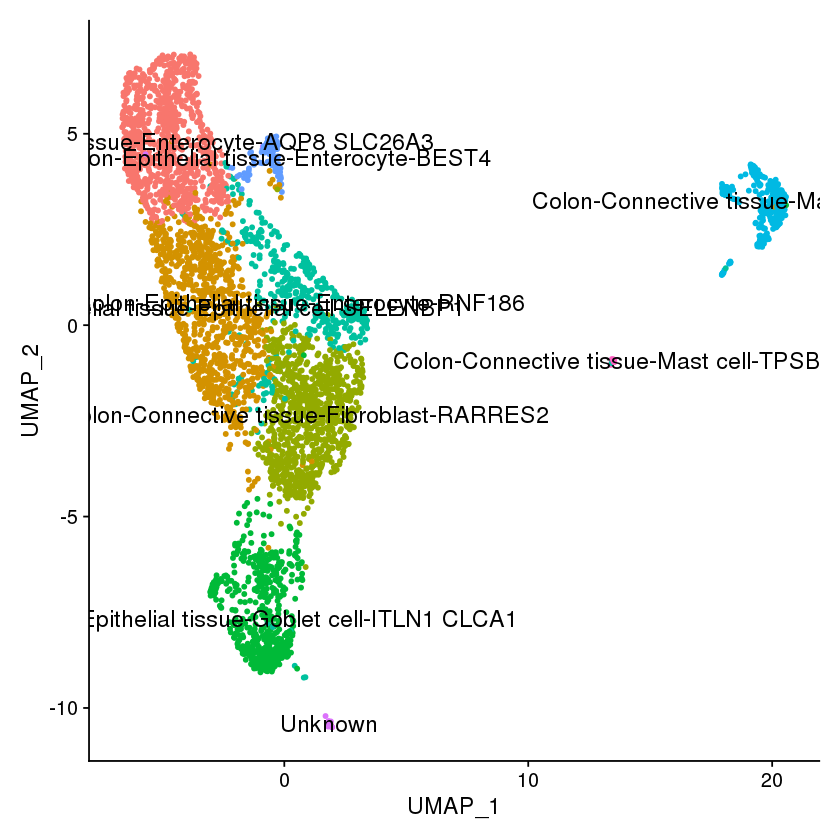

In [49]:
p_umap4 <- UMAPPlot(annodataobj,label = T, pt.size=1,label.size=5)+NoLegend()
p_umap4

In [35]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [51]:

write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(annodataobj@active.ident),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [52]:
print(unique(dataobj$sample_status))
dataobj

[1] normal
3 Levels: inflamed Ulcerative Colitis ... normal


An object of class Seurat 
43878 features across 4249 samples within 1 assay 
Active assay: RNA (43878 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In [54]:
dataobj.dbupload_v1 <- CreateSeuratObject(result_data_out)
# dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v1[['orig.ident']] <- NULL
dataobj.dbupload_v1[['nCount_RNA']] <- NULL
dataobj.dbupload_v1[['nFeature_RNA']] <- NULL
dataobj.dbupload_v1$user_id <- 1
dataobj.dbupload_v1$study_id<-"10.1038/s41586-019-0992-y"
dataobj.dbupload_v1$cell_id <- colnames(dataobj.dbupload_v1@assays$RNA@data)
dataobj.dbupload_v1$organ<-"Colon"
dataobj.dbupload_v1$region<-"NA"
dataobj.dbupload_v1$subregion<-"NA"
dataobj.dbupload_v1$seq_tech<-"10X"
dataobj.dbupload_v1$sample_status<-"Healthy"
dataobj.dbupload_v1$donor_id<-dataobj$donor_ID
dataobj.dbupload_v1$donor_gender<-dataobj$donor_gender
dataobj.dbupload_v1$donor_age<- dataobj$donor_age
dataobj.dbupload_v1$original_name<-dataobj$cell_cluster
dataobj.dbupload_v1$cl_name<-"NA"
dataobj.dbupload_v1$hcad_name<-dataobj$hcad.label

In [55]:
dataobj.dbupload_v1$original_name<-as.character(dataobj.dbupload_v1$original_name)
dataobj.dbupload_v1$donor_id<-as.character(dataobj.dbupload_v1$donor_id)
dataobj.dbupload_v1$donor_gender<-as.character(dataobj.dbupload_v1$donor_gender)

In [63]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [56]:
colnames(dataobj.dbupload_v1@meta.data)

[1] "user_id"       "study_id"      "cell_id"       "organ"        
 [5] "region"        "subgion"       "seq_tech"      "sample_status"
 [9] "donor_id"      "donor_gender"  "donor_age"     "original_name"
[13] "cl_name"       "hcad_name"

In [57]:
dataobj.dbupload_v1

An object of class Seurat 
43878 features across 4249 samples within 1 assay 
Active assay: RNA (43878 features, 0 variable features)

In [61]:
colnames(dataobj.dbupload_v1@meta.data)[6] <- 'subregion'

In [7]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [3]:
dataobj.dbupload_v1 = readRDS(file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))